In [1]:
import sys, os
sys.path.append('/home/lhc/ST-CCC-benchmarking/SpaOTsc')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from spaotsc import SpaOTsc
from sklearn.metrics import matthews_corrcoef, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import binarize, normalize
from sklearn.mixture import GaussianMixture
from scipy import sparse
import seaborn as sns

%pwd

'/home/lhc/ST-CCC-benchmarking'

In [57]:
def preprocess_pathway(root_dir):
    file_name = 'noise_cc_interactions'
    lrpair_name = 'lrpair.csv'
    pathway_name = 'pathway.csv'

    # ite_dir = './ten_benchmarking_dataset'
    # value_lst = ['_0.3_0.1.csv', '_0.3_0.05.csv', '_0.3_0.csv', '_0.15_0.1.csv', '_0.15_0.csv', '_0.15_0.05.csv']
    # for tissue_n in range(1, 5):
    #     ct_num = 5 if tissue_n <= 2 else 3
    #     for bcmk_n in range(1, 11):
    #         for i in value_lst:
    data_large = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
    grn_data = pd.read_csv(os.path.join(root_dir, 'grn.csv'))
    # * L-R pairs
    filtered = data_large[['ligand', 'receptor']]
    filtered['species'] = 'Human'
    # filtered = filtered.rename(columns={'from': 'ligand', 'target': 'receptor'})
    # filtered = filtered[(filtered['ligand'].str[0] == 'L') & (filtered['receptor'].str[0] == 'R')]
    filtered.index = range(1, filtered.shape[0] + 1)
    filtered.drop_duplicates().to_csv(os.path.join(root_dir, lrpair_name))
    print('finish lrpair', os.path.join(root_dir, lrpair_name))

    # * pathway
    pathway = grn_data[['regulator', 'target']]
    pathway = pathway.rename(columns={'regulator': 'src', 'target': 'dest'})
    pathway['pathway'] = 'Various types of N-glycan biosynthesis'
    pathway['source'] = 'KEGG'
    pathway['type'] = 'Process(missing)'
    pathway['src_tf'] = 'YES'
    pathway['dest_tf'] = 'YES'
    pathway.loc[pathway['dest'].str.slice(4).astype(int) >= 54, 'dest_tf'] = 'NO'
    pathway['species'] = 'Human'
    pathway.index = range(1, pathway.shape[0] + 1)
    pathway.to_csv(os.path.join(root_dir, pathway_name))
    print('finish pathway', os.path.join(root_dir, pathway_name))
    
def self_pcc_mat(x, progress=False):
    x_minus_mu = np.empty_like(x)
    for i in range(x.shape[0]):
        x_minus_mu[i,:] = x[i,:] - np.mean(x[i,:])
    x_std = np.empty([x.shape[0]], float)
    for i in range(x.shape[0]):
        x_std[i] = np.linalg.norm(x_minus_mu[i,:])
        if x_std[i] == 0: x_std[i] = 1
    pmat = np.ones( [x.shape[0], x.shape[0]], float )
    for i in range(x.shape[0]-1):
#         if progress: print(i)
        for j in range(i+1, x.shape[0]):
            c = np.dot(x_minus_mu[i,:], x_minus_mu[j,:]) / (x_std[i]*x_std[j])
            pmat[i,j] = c; pmat[j,i] = c
    return pmat

def get_mcc(true_labels, pred_labels):
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
    mcc = (TP * TN) - (FP * FN)
    denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    if denom==0:
        return 0
    return mcc / denom

def preprocess_2(root_dir):
    file_name = 'bcmk_data_position_expression_real_cells.csv'
    sc_file_name = 'bcmk_sc_data_processed.txt'
    bin_file_name = 'sc_isg_binarized.txt'
    mcc_file_name = 'sc_is_mcc.npy'
    pcc_file = 'pcc_pca20.npy'
    df_sc_large = pd.read_csv(os.path.join(root_dir, 'counts.csv'), index_col=0).T
    genes = df_sc_large.columns.values

    # normalize
    df = df_sc_large
    x = np.array( df.values, float )
    x = np.log( x + 1.0 )
    for i in range(x.shape[1]):
        if np.std(x[:,i]) == 0:
            x[:, i] = 0.001
        else:
            x[:,i] = (x[:,i] - np.mean(x[:,i]))/np.std(x[:,i])
    df_new = pd.DataFrame(data=x, columns=df.columns.values, index=df.index.values)
    df_new.to_csv(os.path.join(root_dir, sc_file_name), sep='\t')
    df_sc_large.T.to_csv(os.path.join(root_dir, "giotto_counts.txt"), sep='\t')
    
    pcc_mat = self_pcc_mat(x, progress=True)
    np.save(os.path.join(root_dir, pcc_file), pcc_mat)
    
    df_sc = pd.read_csv(os.path.join(root_dir, sc_file_name), sep='\t', index_col=0)
    genes = df_sc.columns.values
    sp_genes = genes
    sp_genes = list(sp_genes)
    x_sc = np.array( df_sc.values, float )
    sc_genes = list( df_sc.columns.values )
    gind = []
    for g in sp_genes:
        gind.append(sc_genes.index(g))
    gind = np.array(gind, int)
    x_sc = x_sc[:, gind]
    df_sc_part = pd.DataFrame(data=x_sc, columns=sp_genes)
    x_sc_bin = np.empty_like( x_sc )
    for i in range(x_sc.shape[1]):
        GM = GaussianMixture(n_components=2)
        tmp = GM.fit_predict(x_sc[:,i].reshape(-1,1))
    #     print(GM.means_)
        if GM.means_[0,0] > GM.means_[1,0]:
            x_sc_bin[:,i] = 1.0 - tmp[:]
        else:
            x_sc_bin[:,i] = tmp[:]
    df_sc_bin = pd.DataFrame(data=x_sc_bin, columns=sp_genes)
    df_sc_bin.to_csv(os.path.join(root_dir, bin_file_name), sep='\t')
    
    loc_data = pd.read_csv(os.path.join(root_dir, 'locs.csv'), index_col=0)
    loc_data.to_csv(os.path.join(root_dir, 'spatalk_sc_st_data.csv'))
    loc_data.to_csv(os.path.join(root_dir, 'giotto_loc.csv'), header=False, index=False)
    
    print('finish binarized', os.path.join(root_dir, bin_file_name))
    sc_st_data = pd.read_csv(os.path.join(root_dir, 'spatalk_sc_st_data.csv'))
    is_dmat_large =squareform(pdist(sc_st_data.loc[:, ['x', 'y']],metric='euclidean'))
    print(is_dmat_large.shape)
    sparse.save_npz(os.path.join(root_dir, 'is_mat.npz'), sparse.coo_matrix(is_dmat_large))
    
    mcc_all = np.asarray([get_mcc(p, g) for p in x_sc_bin for g in x_sc_bin])
    mcc_all = mcc_all.reshape(len(x_sc_bin),-1)
    np.save(os.path.join(root_dir, mcc_file_name), mcc_all)
    

def run(root_dir):
    # print('START --- ', os.path.join(ite_dir, 'tissue_{}'.format(tissue_n), 'ten_benchmark_data_{}'.format(bcmk_n)))
    sc_st_data = pd.read_csv(os.path.join(root_dir, 'spatalk_sc_st_data.csv'))
    is_dmat_large =squareform(pdist(sc_st_data.loc[:, ['x', 'y']],metric='euclidean'))
    # is_dmat_large = sparse.load_npz(os.path.join(root_dir, 'is_mat.npz')).todense()
    print(is_dmat_large.shape)
    sparse.save_npz(os.path.join(root_dir, 'is_mat.npz'), sparse.coo_matrix(is_dmat_large))
    df_sc = pd.read_csv(os.path.join(root_dir, 'bcmk_sc_data_processed.txt') , sep='\t', index_col=0)
    df_sc_bin = pd.read_csv(os.path.join(root_dir, 'sc_isg_binarized.txt'), sep='\t', index_col=0)

    df_is_bin = df_sc_bin
    sc_pcc = np.load(os.path.join(root_dir, 'pcc_pca20.npy'))
    mcc = np.load(os.path.join(root_dir, 'sc_is_mcc.npy'))
    issc = SpaOTsc.spatial_sc(
        sc_data=df_sc,
        sc_data_bin=df_sc_bin,
        is_data_bin=df_is_bin,
        sc_dmat = np.exp(1-sc_pcc),
        is_dmat=is_dmat_large)

    issc.cell_cell_distance(sc_dmat_spatial=is_dmat_large)
    issc.clustering(pca_n_components=2)
    issc.nonspatial_correlation()
    return issc
    
    
def get_result(root_dir, issc):
    lr_pair = pd.read_csv(os.path.join(root_dir, 'lrpair.csv')).loc[:, ['ligand', 'receptor']]
    cell_info = pd.read_csv(os.path.join(root_dir, 'cell_info.csv'), index_col=0)
    ct_num = len(np.unique(cell_info.loc[:, "cell.type.idx"].to_numpy()))
    idx_dict = {}
    for i in range(1, ct_num+1):
        idx_dict[i] = cell_info['cell.type.idx'] == i
    S_name_a_b = {}
    for l, r in lr_pair.values.astype(str):
        # only calculate matched L-P pairs
        # if l[1:] != r[1:]:
        #     continue
        ccc = issc.spatial_signaling_ot([l], [r])
        S_cluster_a_b = np.zeros([ct_num, ct_num], float)
        for clusterA in range(1, ct_num+1):
            for clusterB in range(1, ct_num+1):
                idx_a = idx_dict[clusterA]
                idx_b = idx_dict[clusterB]
                # print(ccc.shape, idx_a.shape, idx_b.shape)
                C = ccc[idx_a,:][:,idx_b]
                # take average of all cells from this cell-type pair in the score matrix from SpaOTsc
                S_cluster_a_b[clusterA-1, clusterB-1] = np.mean(C)
        S_name_a_b[f"{l}-{r}"] = S_cluster_a_b
    col_name = ['CT'+str(i)+'-'+'CT'+str(j) for i in range(1, 6) for j in range(1, 6)]
    spaot_rlt = pd.DataFrame(index=col_name)
    # lr_cols = ['L'+str(i) +'-'+ 'R' + str(j) for i in range(1, 17) for j in range(1, 17)]
    for pre_pair in S_name_a_b.keys():
        spaot_rlt[pre_pair] = S_name_a_b[pre_pair].reshape(-1)
    spaot_rlt.T.to_csv(os.path.join(root_dir, 'spaot_results.csv'))

In [7]:
dirs = []

for tree in [1, 3, 5]:
    for ncell in [500, 800]:
        for ngene in [110, 200, 500]:
            for sigma in [0.1, 0.5]:
                for seed in [1, 2, 3, 4]:
                    # root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                    root_dir = f"/data/1/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                    dirs.append(root_dir)

In [64]:
dirs5 = []

for tree in [5]:
    for ncell in [500, 800]:
        for ngene in [110, 200, 500]:
            for sigma in [0.1, 0.5]:
                for seed in [1, 2, 3, 4]:
                    root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                    dirs5.append(root_dir)

In [65]:
for root_dir in dirs5:
    preprocess_pathway(root_dir)
    preprocess_2(root_dir)
    issc = run(root_dir)
    get_result(root_dir, issc)

/tmp/ipykernel_120540/1362436290.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['species'] = 'Human'


finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_1/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [54, 27, 16, 7]
1 3 [54, 35, 15]
2 4 [54, 32, 14, 4]
3 5 [30, 27, 26, 20, 1]
4 3 [32, 30, 22]
0 104 gene8
gene8
gene68
gene99
gene100
gene60
0 0 54 gene8
gene8
gene60
gene99
gene88
gene100
0 1 27 gene8
gene8
gene68
gene99
gene100
gene60
0 2 16 gene8
gene8
gene58
gene68
gene76
gene100
0 3 7 gene56
gene56
gene52
gene68
gene8
gene85
1 104 gene33
gene33
gene55
gene101
gene106
gene90
1 0 54 gene33
gene33
gene55
gene101
gene90
gene106
1 1 35 gene33
gene33
gene106
gene55
gene2
gene101
1 2 15 gene55
gene55
gene101
gene90
gene40
gene33
2 104 gene15
gene15
gene38
gene57
gene59
gene66
2 0 54 gene59
gene59
gene15
gene57
gene66
gene38
2 1 32 gene98
gene98
gene15
gene

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 301
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_2/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 5 [42, 23, 20, 18, 1]
1 4 [44, 31, 14, 3]
2 2 [43, 41]
3 3 [46, 17, 8]
4 5 [35, 15, 11, 9, 1]
5 6 [13, 11, 9, 9, 2, 1]
6 4 [18, 7, 7, 1]
0 104 gene25
gene25
gene109
gene110
gene91
gene76
0 0 42 gene25
gene25
gene110
gene91
gene76
gene23
0 1 23 gene25
gene25
gene109
gene110
gene76
gene91
0 2 20 gene25
gene25
gene110
gene109
gene91
gene74
0 3 18 gene25
gene25
gene91
gene76
gene23
gene61
1 92 gene92
gene92
gene62
gene6
gene38
gene63
1 0 44 gene92
gene92
gene62
gene56
gene6
gene63
1 1 31 gene92
gene92
gene6
gene85
gene62
gene38
1 2 14 gene38
gene38
gene69
gene92
gene49
gene62
2 84 gene33
gene33
gene75
gene34
gene31
gene61
2 0 43 gene31
gene31
gene33
gene94
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 490
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/s

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_3/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 3 [46, 40, 21]
1 4 [48, 24, 16, 7]
2 4 [34, 27, 16, 7]
3 4 [34, 14, 13, 7]
4 3 [36, 13, 11]
5 4 [31, 11, 2, 1]
6 3 [32, 6, 3]
0 107 gene32
gene32
gene27
gene65
gene20
gene9
0 0 46 gene32
gene32
gene27
gene65
gene20
gene64
0 1 40 gene27
gene27
gene32
gene65
gene20
gene9
0 2 21 gene32
gene32
gene20
gene27
gene65
gene1
1 95 gene94
gene94
gene49
gene39
gene56
gene109
1 0 48 gene94
gene94
gene39
gene49
gene109
gene22
1 1 24 gene94
gene94
gene39
gene49
gene56
gene24
1 2 16 gene56
gene56
gene49
gene94
gene70
gene39
1 3 7 gene44
gene44
gene94
gene49
gene24
gene91
2 84 gene88
gene88
gene45
gene36
gene109
gene8
2 0 34 gene36
gene36
gene45
gene83
gene105
gene8
2 1 27

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 461
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 598
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 635
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_4/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [40, 31, 26, 7]
1 4 [37, 32, 22, 13]
2 4 [33, 24, 21, 7]
3 4 [35, 22, 19, 8]
4 5 [40, 32, 7, 1, 1]
5 5 [19, 15, 4, 2, 2]
0 104 gene68
gene68
gene33
gene45
gene88
gene21
0 0 40 gene68
gene68
gene88
gene45
gene30
gene33
0 1 31 gene21
gene21
gene33
gene26
gene45
gene68
0 2 26 gene88
gene88
gene45
gene68
gene102
gene33
0 3 7 gene102
gene102
gene101
gene74
gene61
gene68
1 104 gene3
gene3
gene89
gene78
gene1
gene86
1 0 37 gene3
gene3
gene89
gene78
gene1
gene86
1 1 32 gene89
gene89
gene3
gene54
gene1
gene78
1 2 22 gene3
gene3
gene89
gene7
gene1
gene78
1 3 13 gene89
gene89
gene3
gene108
gene78
gene1
2 85 gene87
gene87
gene95
gene90
gene81
gene69
2 0 33 gene87
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 704
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 289
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 586
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 445
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_1/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 3 [50, 21, 20]
1 3 [42, 30, 10]
2 3 [33, 29, 6]
3 3 [62, 1, 1]
4 4 [20, 17, 15, 10]
5 4 [24, 21, 9, 2]
6 4 [16, 13, 12, 8]
7 6 [12, 5, 5, 4, 1, 1]
0 91 gene66
gene66
gene59
gene15
gene53
gene38
0 0 50 gene66
gene66
gene59
gene15
gene53
gene98
0 1 21 gene66
gene66
gene59
gene88
gene15
gene49
0 2 20 gene15
gene15
gene59
gene42
gene66
gene71
1 82 gene106
gene106
gene33
gene1
gene109
gene48
1 0 42 gene106
gene106
gene34
gene109
gene61
gene104
1 1 30 gene33
gene33
gene21
gene106
gene40
gene1
1 2 10 gene1
gene1
gene45
gene110
gene21
gene10
2 68 gene59
gene59
gene15
gene11
gene53
gene72
2 0 33 gene66
gene66
gene72
gene59
gene62
gene63
2 1 29 gene11
gene11
gene59


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 254
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 210
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 645
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_2/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [36, 23, 19, 11]
1 3 [43, 24, 22]
2 3 [41, 24, 17]
3 4 [26, 25, 5, 3]
4 6 [17, 15, 14, 4, 1, 1]
5 4 [17, 11, 11, 11]
6 6 [14, 7, 5, 4, 2, 1]
7 7 [11, 10, 4, 2, 1, 1, 1]
8 6 [6, 3, 3, 2, 1, 1]
0 89 gene71
gene71
gene52
gene17
gene67
gene55
0 0 36 gene55
gene55
gene71
gene52
gene17
gene38
0 1 23 gene67
gene67
gene52
gene71
gene38
gene17
0 2 19 gene85
gene85
gene71
gene50
gene52
gene59
0 3 11 gene52
gene52
gene71
gene17
gene62
gene44
1 89 gene25
gene25
gene107
gene33
gene21
gene75
1 0 43 gene25
gene25
gene107
gene20
gene21
gene32
1 1 24 gene25
gene25
gene107
gene32
gene76
gene75
1 2 22 gene33
gene33
gene61
gene27
gene75
gene74
2 82 gene34
gene34
gene91
gene

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 877
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 789
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 417
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_3/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [40, 38, 6, 4]
1 2 [41, 39]
2 4 [29, 24, 10, 7]
3 5 [22, 16, 10, 10, 4]
4 7 [17, 14, 12, 6, 5, 1, 1]
5 4 [24, 15, 11, 5]
6 3 [25, 18, 8]
7 6 [17, 11, 5, 3, 1, 1]
0 88 gene88
gene88
gene45
gene36
gene109
gene8
0 0 40 gene36
gene36
gene88
gene45
gene109
gene8
0 1 38 gene88
gene88
gene45
gene36
gene109
gene28
0 2 6 gene88
gene88
gene45
gene36
gene74
gene83
0 3 4 gene46
gene46
gene57
gene107
gene53
gene81
1 80 gene32
gene32
gene72
gene98
gene20
gene41
1 0 41 gene72
gene72
gene98
gene32
gene41
gene44
1 1 39 gene32
gene32
gene20
gene98
gene72
gene27
2 70 gene39
gene39
gene48
gene2
gene56
gene109
2 0 29 gene109
gene109
gene18
gene90
gene2
gene48
2 1 24 gene39
g

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 575
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_4/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 6 [20, 18, 18, 9, 7, 4]
1 4 [24, 20, 14, 7]
2 6 [19, 17, 13, 11, 3, 1]
3 3 [28, 24, 10]
4 3 [24, 16, 8]
5 4 [32, 5, 4, 2]
6 4 [21, 17, 1, 1]
7 3 [21, 11, 7]
8 5 [24, 8, 3, 2, 1]
9 5 [9, 6, 6, 3, 1]
0 76 gene67
gene67
gene94
gene56
gene50
gene16
0 0 20 gene94
gene94
gene67
gene11
gene56
gene50
0 1 18 gene71
gene71
gene67
gene29
gene38
gene50
0 2 18 gene94
gene94
gene13
gene66
gene67
gene29
0 3 9 gene50
gene50
gene71
gene67
gene44
gene94
0 4 7 gene16
gene16
gene38
gene85
gene67
gene71
0 5 4 gene4
gene4
gene99
gene38
gene27
gene16
1 65 gene90
gene90
gene87
gene84
gene95
gene64
1 0 24 gene90
gene90
gene84
gene87
gene95
gene81
1 1 20 gene87
gene87
gene90
gene64

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 573
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 333
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 334
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_1/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [51, 22, 20, 11]
1 5 [62, 29, 11, 1, 1]
2 5 [40, 22, 20, 11, 11]
3 5 [62, 17, 15, 9, 1]
4 2 [54, 30]
0 104 gene57
gene57
gene87
gene90
gene81
gene64
0 0 51 gene57
gene57
gene87
gene90
gene81
gene172
0 1 22 gene81
gene81
gene87
gene90
gene172
gene57
0 2 20 gene57
gene57
gene87
gene90
gene64
gene172
0 3 11 gene57
gene57
gene84
gene65
gene64
gene90
1 104 gene112
gene112
gene120
gene141
gene94
gene19
1 0 62 gene94
gene94
gene100
gene120
gene112
gene141
1 1 29 gene112
gene112
gene91
gene120
gene122
gene19
1 2 11 gene141
gene141
gene152
gene125
gene105
gene94
2 104 gene36
gene36
gene78
gene129
gene88
gene119
2 0 40 gene36
gene36
gene129
gene88
gene78
gene119
2

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 320
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 329
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 912
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 537
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_2/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 5 [35, 23, 14, 14, 13]
1 4 [32, 27, 17, 14]
2 3 [31, 28, 25]
3 3 [29, 26, 18]
4 5 [33, 21, 12, 1, 1]
5 4 [15, 13, 12, 5]
6 5 [13, 12, 11, 3, 2]
0 99 gene187
gene187
gene124
gene148
gene193
gene79
0 0 35 gene187
gene187
gene157
gene124
gene148
gene79
0 1 23 gene187
gene187
gene124
gene79
gene96
gene193
0 2 14 gene187
gene187
gene96
gene148
gene124
gene183
0 3 14 gene187
gene187
gene96
gene124
gene174
gene157
0 4 13 gene148
gene148
gene193
gene187
gene77
gene124
1 90 gene129
gene129
gene173
gene113
gene110
gene92
1 0 32 gene113
gene113
gene173
gene129
gene16
gene110
1 1 27 gene110
gene110
gene173
gene129
gene92
gene16
1 2 17 gene129
gene129
gene130
gene107
g

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 222
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 295
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 182
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_3/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 2 [62, 42]
1 1 [84]
2 4 [38, 35, 3, 1]
3 3 [36, 20, 13]
4 4 [26, 19, 16, 1]
5 7 [17, 13, 11, 9, 9, 1, 1]
6 3 [18, 13, 12]
0 104 gene43
gene43
gene33
gene26
gene25
gene146
0 0 62 gene146
gene146
gene33
gene43
gene26
gene25
0 1 42 gene99
gene99
gene43
gene25
gene26
gene33
1 84 gene104
gene104
gene90
gene154
gene137
gene160
1 0 84 gene104
gene104
gene90
gene154
gene137
gene160
2 77 gene192
gene192
gene36
gene88
gene58
gene193
2 0 38 gene193
gene193
gene36
gene88
gene192
gene164
2 1 35 gene36
gene36
gene192
gene88
gene58
gene76
3 69 gene192
gene192
gene36
gene58
gene163
gene162
3 0 36 gene36
gene36
gene192
gene58
gene60
gene163
3 1 20 gene192
gene192
gene162
g

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 472
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 241
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 535
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 440
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_4/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [52, 35, 17, 11]
1 4 [45, 34, 17, 10]
2 2 [53, 31]
3 6 [18, 13, 13, 12, 5, 2]
4 3 [30, 14, 14]
5 3 [21, 14, 9]
6 5 [16, 5, 4, 4, 1]
0 115 gene172
gene172
gene192
gene161
gene142
gene166
0 0 52 gene142
gene142
gene172
gene192
gene161
gene122
0 1 35 gene172
gene172
gene105
gene161
gene199
gene160
0 2 17 gene131
gene131
gene161
gene192
gene115
gene166
0 3 11 gene194
gene194
gene136
gene142
gene115
gene156
1 106 gene65
gene65
gene31
gene45
gene21
gene33
1 0 45 gene65
gene65
gene31
gene27
gene21
gene48
1 1 34 gene65
gene65
gene31
gene45
gene33
gene21
1 2 17 gene31
gene31
gene47
gene65
gene45
gene57
1 3 10 gene57
gene57
gene31
gene25
gene65
gene47
2 84 gene87


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 584
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_1/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [29, 12, 12, 8]
1 4 [20, 15, 12, 12]
2 3 [29, 25, 5]
3 3 [25, 21, 9]
4 2 [42, 12]
5 3 [19, 17, 17]
6 5 [15, 15, 12, 5, 1]
7 4 [29, 10, 3, 1]
8 3 [20, 11, 4]
9 5 [10, 10, 5, 4, 4]
0 61 gene56
gene56
gene65
gene61
gene7
gene64
0 0 29 gene7
gene7
gene155
gene64
gene65
gene68
0 1 12 gene61
gene61
gene139
gene48
gene56
gene32
0 2 12 gene38
gene38
gene50
gene52
gene17
gene92
0 3 8 gene131
gene131
gene122
gene91
gene99
gene18
1 59 gene27
gene27
gene21
gene20
gene33
gene25
1 0 20 gene98
gene98
gene21
gene27
gene47
gene33
1 1 15 gene33
gene33
gene20
gene25
gene21
gene27
1 2 12 gene20
gene20
gene21
gene27
gene99
gene47
1 3 12 gene96
gene96
gene22
gene27
gene44
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 628
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 364
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 387
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You mi

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_2/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 3 [43, 31, 27]
1 3 [37, 26, 22]
2 2 [58, 26]
3 4 [30, 27, 11, 11]
4 3 [25, 23, 8]
5 4 [16, 12, 12, 10]
6 3 [20, 17, 8]
0 101 gene116
gene116
gene173
gene106
gene169
gene198
0 0 43 gene116
gene116
gene173
gene198
gene188
gene172
0 1 31 gene187
gene187
gene76
gene181
gene174
gene106
0 2 27 gene139
gene139
gene169
gene113
gene73
gene165
1 85 gene188
gene188
gene1
gene171
gene173
gene16
1 0 37 gene188
gene188
gene171
gene168
gene118
gene160
1 1 26 gene173
gene173
gene172
gene16
gene110
gene186
1 2 22 gene150
gene150
gene86
gene87
gene188
gene30
2 84 gene20
gene20
gene11
gene34
gene75
gene44
2 0 58 gene20
gene20
gene11
gene34
gene75
gene44
2 1 26 gene20
gene20


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 332
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 510
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_3/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [22, 22, 18, 18]
1 1 [74]
2 4 [29, 17, 10, 8]
3 4 [24, 15, 14, 8]
4 4 [25, 22, 6, 1]
5 4 [24, 20, 3, 2]
6 4 [20, 16, 3, 2]
7 4 [13, 13, 5, 3]
8 6 [12, 3, 2, 2, 2, 2]
9 3 [10, 8, 2]
0 80 gene42
gene42
gene75
gene1
gene54
gene9
0 0 22 gene5
gene5
gene61
gene9
gene31
gene75
0 1 22 gene166
gene166
gene65
gene51
gene15
gene63
0 2 18 gene164
gene164
gene58
gene162
gene136
gene111
0 3 18 gene54
gene54
gene153
gene157
gene182
gene42
1 74 gene104
gene104
gene154
gene90
gene160
gene96
1 0 74 gene104
gene104
gene154
gene90
gene160
gene96
2 64 gene163
gene163
gene178
gene185
gene110
gene99
2 0 29 gene163
gene163
gene178
gene91
gene110
gene108
2 1 17 gene155
gene155


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 223
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 315
  warnings.warn('Warning: numerical errors at iteratio

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_4/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 3 [31, 28, 24]
1 4 [25, 25, 18, 13]
2 4 [23, 20, 18, 15]
3 4 [36, 18, 8, 5]
4 6 [15, 12, 8, 8, 7, 1]
5 4 [27, 12, 7, 5]
6 5 [14, 8, 8, 6, 1]
7 4 [15, 10, 6, 1]
8 5 [9, 7, 3, 2, 1]
0 83 gene33
gene33
gene31
gene47
gene66
gene98
0 0 31 gene50
gene50
gene66
gene98
gene10
gene72
0 1 28 gene33
gene33
gene47
gene31
gene98
gene66
0 2 24 gene65
gene65
gene47
gene31
gene27
gene43
1 81 gene87
gene87
gene132
gene56
gene93
gene35
1 0 25 gene87
gene87
gene82
gene185
gene132
gene165
1 1 25 gene56
gene56
gene35
gene62
gene50
gene98
1 2 18 gene93
gene93
gene178
gene32
gene87
gene60
1 3 13 gene102
gene102
gene153
gene137
gene11
gene172
2 76 gene66
gene66
gene98
gene50
gene

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 841
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 357
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_1/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [33, 19, 17, 15]
1 5 [19, 17, 13, 10, 9]
2 4 [36, 13, 11, 8]
3 6 [24, 15, 13, 8, 2, 2]
4 4 [27, 19, 12, 4]
5 6 [19, 15, 6, 5, 4, 1]
6 4 [20, 7, 6, 3]
7 7 [12, 8, 8, 3, 2, 2, 1]
8 3 [16, 11, 5]
0 84 gene111
gene111
gene423
gene197
gene253
gene66
0 0 33 gene253
gene253
gene438
gene423
gene329
gene316
0 1 19 gene156
gene156
gene421
gene66
gene85
gene382
0 2 17 gene197
gene197
gene15
gene111
gene382
gene38
0 3 15 gene328
gene328
gene196
gene111
gene340
gene122
1 68 gene450
gene450
gene207
gene466
gene91
gene363
1 0 19 gene363
gene363
gene466
gene91
gene469
gene370
1 1 17 gene450
gene450
gene218
gene466
gene91
gene370
1 2 13 gene306
gene306
gene466
gene207
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 247
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 289
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 705
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_2/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [58, 31, 10, 4]
1 3 [50, 29, 24]
2 3 [47, 21, 16]
3 3 [31, 27, 22]
4 6 [22, 16, 12, 9, 2, 2]
5 5 [17, 10, 10, 3, 2]
6 4 [12, 8, 4, 1]
0 103 gene271
gene271
gene31
gene77
gene34
gene16
0 0 58 gene77
gene77
gene271
gene31
gene34
gene16
0 1 31 gene31
gene31
gene298
gene34
gene271
gene77
0 2 10 gene151
gene151
gene54
gene271
gene16
gene395
0 3 4 gene25
gene25
gene271
gene392
gene66
gene7
1 103 gene357
gene357
gene481
gene307
gene488
gene372
1 0 50 gene357
gene357
gene307
gene372
gene481
gene488
1 1 29 gene357
gene357
gene471
gene481
gene488
gene14
1 2 24 gene357
gene357
gene481
gene488
gene14
gene490
2 84 gene81
gene81
gene20
gene499
gene173
gene64
2 0 47 ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 520
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 688
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 662
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_3/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 3 [49, 31, 30]
1 4 [39, 24, 18, 17]
2 3 [30, 28, 26]
3 4 [28, 25, 19, 8]
4 3 [27, 26, 6]
5 3 [20, 16, 9]
6 5 [12, 7, 3, 1, 1]
0 110 gene288
gene288
gene478
gene445
gene472
gene210
0 0 49 gene319
gene319
gene435
gene210
gene63
gene293
0 1 31 gene326
gene326
gene210
gene119
gene293
gene319
0 2 30 gene309
gene309
gene164
gene207
gene478
gene295
1 98 gene290
gene290
gene435
gene472
gene385
gene478
1 0 39 gene385
gene385
gene435
gene212
gene166
gene469
1 1 24 gene435
gene435
gene478
gene472
gene207
gene164
1 2 18 gene113
gene113
gene456
gene293
gene212
gene290
1 3 17 gene290
gene290
gene113
gene326
gene210
gene287
2 84 gene346
gene346
gene33
gene500
gene84
gene

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 851
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 548
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You migh

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_4/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 1 [84]
1 3 [32, 30, 15]
2 3 [37, 19, 15]
3 5 [49, 4, 3, 3, 3]
4 3 [28, 24, 8]
5 5 [19, 18, 11, 5, 4]
6 4 [17, 15, 11, 2]
7 5 [26, 7, 5, 4, 2]
0 84 gene410
gene410
gene304
gene192
gene89
gene60
0 0 84 gene410
gene410
gene304
gene192
gene89
gene60
1 77 gene161
gene161
gene249
gene7
gene62
gene50
1 0 32 gene161
gene161
gene249
gene483
gene50
gene314
1 1 30 gene10
gene10
gene161
gene7
gene42
gene62
1 2 15 gene161
gene161
gene99
gene483
gene386
gene15
2 71 gene21
gene21
gene57
gene48
gene65
gene93
2 0 37 gene21
gene21
gene93
gene47
gene48
gene65
2 1 19 gene57
gene57
gene87
gene48
gene65
gene21
2 2 15 gene161
gene161
gene47
gene31
gene57
gene81
3 62 gene261
gene

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 625
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 499
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 744
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 704
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_1/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [35, 24, 19, 6]
1 4 [38, 18, 18, 9]
2 5 [34, 17, 15, 6, 1]
3 3 [37, 19, 8]
4 3 [35, 16, 10]
5 4 [24, 19, 9, 3]
6 5 [18, 11, 11, 6, 4]
7 6 [9, 7, 6, 5, 2, 1]
0 84 gene71
gene71
gene66
gene85
gene67
gene79
0 0 35 gene62
gene62
gene71
gene66
gene15
gene49
0 1 24 gene79
gene79
gene39
gene249
gene67
gene15
0 2 19 gene66
gene66
gene85
gene71
gene69
gene316
0 3 6 gene60
gene60
gene98
gene72
gene473
gene24
1 83 gene267
gene267
gene160
gene377
gene450
gene350
1 0 38 gene160
gene160
gene450
gene371
gene370
gene350
1 1 18 gene267
gene267
gene450
gene370
gene160
gene107
1 2 18 gene267
gene267
gene377
gene375
gene152
gene194
1 3 9 gene230
gene230
gene152
gene159
gene

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 226
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 372
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 402
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You mi

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_2/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [43, 18, 15, 10]
1 3 [37, 17, 10]
2 5 [21, 21, 11, 7, 1]
3 4 [42, 12, 3, 1]
4 5 [18, 11, 10, 8, 8]
5 4 [24, 13, 8, 2]
6 4 [18, 15, 9, 5]
7 6 [15, 12, 7, 6, 4, 1]
8 3 [20, 12, 5]
0 86 gene354
gene354
gene481
gene463
gene459
gene282
0 0 43 gene493
gene493
gene481
gene197
gene354
gene107
0 1 18 gene76
gene76
gene150
gene463
gene311
gene243
0 2 15 gene483
gene483
gene202
gene354
gene201
gene179
0 3 10 gene257
gene257
gene137
gene197
gene319
gene237
1 64 gene188
gene188
gene198
gene197
gene354
gene481
1 0 37 gene500
gene500
gene188
gene198
gene282
gene197
1 1 17 gene481
gene481
gene463
gene239
gene325
gene243
1 2 10 gene465
gene465
gene428
gene337
gene398
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 381
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_3/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [49, 18, 13, 12]
1 4 [33, 24, 17, 17]
2 3 [45, 23, 15]
3 5 [22, 15, 13, 10, 7]
4 5 [18, 16, 11, 11, 5]
5 4 [21, 18, 6, 2]
6 3 [20, 10, 7]
7 6 [6, 5, 4, 3, 2, 2]
0 92 gene391
gene391
gene494
gene395
gene392
gene477
0 0 49 gene395
gene395
gene209
gene86
gene89
gene477
0 1 18 gene494
gene494
gene391
gene461
gene27
gene78
0 2 13 gene182
gene182
gene114
gene64
gene351
gene365
0 3 12 gene19
gene19
gene118
gene391
gene54
gene53
1 91 gene263
gene263
gene161
gene389
gene393
gene476
1 0 33 gene482
gene482
gene498
gene263
gene161
gene147
1 1 24 gene263
gene263
gene393
gene325
gene114
gene418
1 2 17 gene88
gene88
gene272
gene149
gene248
gene295
1 3 17 gene190
gene19

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 669
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 909
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 260
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 437
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_4/cci/sc_isg_binarized.txt
(500, 500)
(500, 500)
0 4 [37, 22, 15, 14]
1 2 [45, 36]
2 4 [28, 26, 14, 12]
3 4 [28, 22, 14, 14]
4 3 [42, 18, 13]
5 4 [17, 17, 11, 8]
6 4 [18, 17, 10, 2]
0 88 gene275
gene275
gene108
gene156
gene325
gene304
0 0 37 gene275
gene275
gene108
gene417
gene179
gene207
0 1 22 gene136
gene136
gene88
gene407
gene410
gene78
0 2 15 gene180
gene180
gene418
gene143
gene431
gene275
0 3 14 gene304
gene304
gene325
gene156
gene318
gene407
1 81 gene87
gene87
gene65
gene57
gene93
gene48
1 0 45 gene65
gene65
gene87
gene57
gene48
gene93
1 1 36 gene57
gene57
gene87
gene40
gene93
gene65
2 80 gene303
gene303
gene199
gene431
gene358
gene143
2 0 28 gene143
gene143
gene434
gene199
gene303
gene450
2 1 26 ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 321
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 413
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 276
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_1/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 3 [82, 37, 15]
1 5 [55, 34, 18, 15, 7]
2 3 [72, 45, 11]
3 5 [57, 36, 12, 7, 2]
4 7 [39, 20, 12, 8, 2, 1, 1]
5 5 [41, 17, 11, 7, 4]
6 8 [22, 9, 7, 4, 3, 3, 2, 1]
7 8 [14, 9, 8, 4, 3, 1, 1, 1]
8 6 [19, 8, 6, 5, 1, 1]
0 134 gene84
gene84
gene78
gene77
gene45
gene69
0 0 82 gene84
gene84
gene78
gene77
gene45
gene69
0 1 37 gene84
gene84
gene77
gene78
gene69
gene45
0 2 15 gene77
gene77
gene84
gene45
gene78
gene65
1 129 gene101
gene101
gene94
gene36
gene22
gene100
1 0 55 gene101
gene101
gene94
gene22
gene36
gene100
1 1 34 gene36
gene36
gene94
gene101
gene22
gene100
1 2 18 gene36
gene36
gene94
gene22
gene101
gene88
1 3 15 gene101
gene101
gene100
gene94
gene22
gene3

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 443
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 564
  warnings.warn('Warning: numerical errors at iteratio

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_2/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 3 [62, 40, 32]
1 7 [46, 27, 24, 13, 10, 10, 1]
2 4 [45, 37, 20, 13]
3 7 [33, 24, 13, 9, 3, 2, 1]
4 5 [27, 19, 15, 11, 10]
5 4 [30, 25, 21, 3]
6 5 [21, 18, 11, 11, 9]
7 4 [23, 17, 17, 9]
8 6 [9, 8, 8, 8, 3, 2]
0 134 gene93
gene93
gene81
gene87
gene84
gene90
0 0 62 gene81
gene81
gene93
gene87
gene84
gene90
0 1 40 gene87
gene87
gene84
gene93
gene81
gene90
0 2 32 gene93
gene93
gene81
gene87
gene90
gene84
1 131 gene71
gene71
gene12
gene17
gene98
gene58
1 0 46 gene12
gene12
gene17
gene71
gene58
gene85
1 1 27 gene71
gene71
gene12
gene98
gene38
gene55
1 2 24 gene17
gene17
gene71
gene55
gene12
gene49
1 3 13 gene71
gene71
gene58
gene35
gene17
gene98
1 4 10 gene49
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 755
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 425
  warnings.warn('Warning: numerical errors at iteratio

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_3/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 7 [25, 22, 17, 16, 6, 1, 1]
1 6 [21, 21, 21, 12, 7, 5]
2 4 [34, 23, 23, 4]
3 5 [28, 25, 15, 15, 1]
4 7 [24, 18, 15, 13, 6, 3, 1]
5 7 [30, 20, 10, 10, 3, 1, 1]
6 3 [31, 21, 20]
7 6 [16, 14, 12, 9, 6, 5]
8 2 [32, 30]
9 8 [22, 10, 9, 6, 3, 1, 1, 1]
10 7 [17, 14, 9, 9, 2, 1, 1]
0 88 gene58
gene58
gene90
gene89
gene93
gene70
0 0 25 gene89
gene89
gene90
gene93
gene58
gene83
0 1 22 gene58
gene58
gene89
gene90
gene70
gene93
0 2 17 gene90
gene90
gene58
gene89
gene93
gene81
0 3 16 gene58
gene58
gene90
gene93
gene89
gene83
0 4 6 gene58
gene58
gene83
gene89
gene93
gene77
1 87 gene93
gene93
gene90
gene89
gene58
gene83
1 0 21 gene89
gene89
gene93
gene58
gene90
gene83
1 

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 698
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 263
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteratio

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_4/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 3 [69, 62, 35]
1 4 [68, 42, 41, 15]
2 5 [41, 36, 33, 27, 6]
3 3 [60, 44, 30]
4 7 [39, 38, 20, 10, 7, 1, 1]
5 7 [26, 22, 13, 11, 1, 1, 1]
0 166 gene67
gene67
gene15
gene29
gene56
gene16
0 0 69 gene67
gene67
gene56
gene50
gene15
gene16
0 1 62 gene67
gene67
gene15
gene16
gene72
gene3
0 2 35 gene29
gene29
gene15
gene67
gene3
gene59
1 166 gene104
gene104
gene106
gene60
gene45
gene102
1 0 68 gene104
gene104
gene106
gene60
gene102
gene45
1 1 42 gene104
gene104
gene106
gene60
gene45
gene88
1 2 41 gene104
gene104
gene106
gene102
gene45
gene60
1 3 15 gene104
gene104
gene45
gene106
gene88
gene102
2 143 gene65
gene65
gene75
gene40
gene33
gene31
2 0 41 gene65
gene65
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 162
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_1/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 7 [41, 33, 24, 12, 8, 6, 1]
1 3 [40, 40, 20]
2 6 [24, 20, 16, 16, 10, 8]
3 6 [26, 24, 20, 8, 1, 1]
4 9 [18, 17, 13, 11, 7, 5, 3, 3, 1]
5 4 [35, 21, 18, 1]
6 6 [25, 25, 17, 4, 3, 1]
7 10 [11, 10, 8, 7, 6, 4, 1, 1, 1, 1]
8 7 [11, 10, 8, 8, 3, 2, 1]
9 8 [12, 10, 6, 5, 4, 3, 1, 1]
10 7 [14, 10, 6, 4, 2, 1, 1]
0 125 gene50
gene50
gene15
gene39
gene59
gene71
0 0 41 gene39
gene39
gene50
gene15
gene98
gene52
0 1 33 gene71
gene71
gene66
gene59
gene50
gene98
0 2 24 gene50
gene50
gene15
gene59
gene52
gene66
0 3 12 gene56
gene56
gene15
gene71
gene59
gene63
0 4 8 gene98
gene98
gene50
gene79
gene15
gene39
0 5 6 gene85
gene85
gene52
gene44
gene79
gene94
1 100 gene5
gene5

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 445
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 400
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 975
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_2/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 5 [34, 28, 23, 17, 10]
1 5 [36, 24, 24, 23, 1]
2 5 [28, 24, 21, 18, 4]
3 4 [32, 26, 19, 14]
4 6 [24, 21, 15, 10, 7, 3]
5 2 [63, 16]
6 4 [27, 21, 17, 5]
7 8 [19, 13, 10, 8, 4, 2, 1, 1]
8 2 [37, 18]
9 6 [19, 15, 7, 5, 5, 1]
0 112 gene71
gene71
gene17
gene55
gene38
gene52
0 0 34 gene71
gene71
gene17
gene55
gene38
gene52
0 1 28 gene71
gene71
gene17
gene55
gene38
gene44
0 2 23 gene49
gene49
gene38
gene71
gene7
gene17
0 3 17 gene71
gene71
gene55
gene98
gene17
gene42
0 4 10 gene98
gene98
gene71
gene53
gene52
gene17
1 108 gene61
gene61
gene31
gene33
gene20
gene34
1 0 36 gene61
gene61
gene31
gene20
gene34
gene33
1 1 24 gene61
gene61
gene21
gene31
gene34
gene20
1 2 

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 249
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 258
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 278
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 282
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_3/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 5 [42, 27, 24, 15, 7]
1 5 [35, 30, 30, 10, 1]
2 5 [36, 30, 17, 12, 3]
3 3 [39, 33, 22]
4 7 [32, 20, 17, 13, 5, 1, 1]
5 8 [24, 15, 14, 13, 5, 2, 1, 1]
6 3 [42, 29, 1]
7 3 [28, 22, 14]
8 8 [18, 13, 7, 7, 5, 1, 1, 1]
9 5 [12, 12, 6, 3, 1]
0 115 gene90
gene90
gene89
gene83
gene85
gene79
0 0 42 gene90
gene90
gene89
gene83
gene58
gene82
0 1 27 gene90
gene90
gene89
gene29
gene79
gene109
0 2 24 gene90
gene90
gene83
gene11
gene89
gene55
0 3 15 gene85
gene85
gene90
gene79
gene89
gene110
0 4 7 gene83
gene83
gene31
gene90
gene26
gene93
1 106 gene41
gene41
gene98
gene109
gene72
gene42
1 0 35 gene109
gene109
gene98
gene41
gene24
gene69
1 1 30 gene98
gene98
gene41
gene72

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 499
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 246
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 909
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 408
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_4/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 7 [33, 27, 26, 21, 1, 1, 1]
1 4 [31, 24, 19, 15]
2 4 [43, 23, 12, 10]
3 7 [30, 22, 14, 12, 6, 3, 1]
4 6 [22, 20, 19, 16, 5, 1]
5 4 [28, 25, 17, 8]
6 5 [26, 15, 13, 12, 3]
7 7 [25, 16, 16, 3, 1, 1, 1]
8 7 [15, 10, 8, 5, 5, 3, 2]
9 4 [15, 11, 11, 9]
10 11 [13, 8, 3, 3, 3, 2, 2, 1, 1, 1, 1]
0 110 gene104
gene104
gene60
gene54
gene106
gene68
0 0 33 gene104
gene104
gene60
gene57
gene54
gene26
0 1 27 gene45
gene45
gene104
gene60
gene106
gene26
0 2 26 gene104
gene104
gene106
gene54
gene30
gene7
0 3 21 gene104
gene104
gene36
gene74
gene54
gene102
1 89 gene65
gene65
gene75
gene40
gene33
gene31
1 0 31 gene65
gene65
gene75
gene40
gene27
gene33
1 1 24 gene65
gene65
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 850
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 264
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 386
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 891
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_1/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 3 [58, 43, 33]
1 8 [40, 19, 18, 14, 13, 9, 2, 1]
2 4 [49, 26, 25, 16]
3 6 [42, 23, 14, 13, 11, 4]
4 4 [34, 31, 23, 16]
5 4 [35, 17, 15, 9]
6 4 [29, 16, 14, 2]
7 7 [18, 18, 7, 5, 2, 1, 1]
8 10 [13, 5, 4, 3, 2, 2, 2, 1, 1, 1]
0 134 gene172
gene172
gene149
gene123
gene94
gene121
0 0 58 gene123
gene123
gene172
gene149
gene94
gene161
0 1 43 gene172
gene172
gene149
gene123
gene94
gene121
0 2 33 gene123
gene123
gene149
gene172
gene161
gene136
1 116 gene64
gene64
gene25
gene57
gene20
gene47
1 0 40 gene64
gene64
gene57
gene20
gene25
gene47
1 1 19 gene25
gene25
gene19
gene64
gene57
gene47
1 2 18 gene25
gene25
gene64
gene57
gene33
gene47
1 3 14 gene19
gene19
gene47
g

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 771
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 170
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 334
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 449
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_2/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 4 [80, 44, 22, 20]
1 3 [53, 49, 32]
2 7 [27, 24, 14, 14, 10, 9, 3]
3 6 [20, 18, 17, 13, 5, 3]
4 8 [17, 15, 10, 9, 9, 8, 2, 1]
5 5 [18, 18, 16, 14, 1]
6 9 [22, 13, 11, 8, 7, 2, 1, 1, 1]
7 7 [14, 13, 13, 10, 6, 5, 1]
8 7 [20, 15, 10, 6, 4, 1, 1]
0 166 gene89
gene89
gene64
gene54
gene48
gene78
0 0 80 gene89
gene89
gene54
gene64
gene81
gene48
0 1 44 gene64
gene64
gene89
gene48
gene54
gene78
0 2 22 gene90
gene90
gene89
gene78
gene64
gene48
0 3 20 gene89
gene89
gene64
gene25
gene57
gene90
1 134 gene148
gene148
gene116
gene146
gene180
gene151
1 0 53 gene116
gene116
gene148
gene191
gene180
gene37
1 1 49 gene146
gene146
gene148
gene116
gene158
gene180
1 2 32 gene15

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 107
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 272
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 434
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 610
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_3/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 5 [54, 44, 32, 24, 18]
1 5 [45, 38, 32, 28, 21]
2 3 [64, 45, 16]
3 8 [30, 24, 22, 15, 13, 1, 1, 1]
4 3 [50, 33, 11]
5 7 [24, 13, 12, 5, 4, 3, 1]
6 3 [17, 15, 8]
7 6 [13, 9, 8, 3, 2, 1]
0 172 gene154
gene154
gene133
gene163
gene192
gene145
0 0 54 gene163
gene163
gene154
gene133
gene145
gene192
0 1 44 gene133
gene133
gene154
gene192
gene163
gene145
0 2 32 gene154
gene154
gene133
gene76
gene192
gene164
0 3 24 gene154
gene154
gene133
gene163
gene145
gene155
0 4 18 gene145
gene145
gene154
gene163
gene150
gene192
1 164 gene185
gene185
gene95
gene84
gene110
gene161
1 0 45 gene185
gene185
gene84
gene159
gene116
gene95
1 1 38 gene110
gene110
gene185
gene123
gene161

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 315
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 280
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 313
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_4/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 4 [66, 44, 34, 21]
1 3 [80, 31, 23]
2 5 [40, 33, 27, 23, 7]
3 6 [32, 24, 21, 21, 17, 5]
4 4 [38, 24, 17, 9]
5 6 [32, 20, 18, 7, 5, 1]
6 4 [38, 17, 15, 10]
0 165 gene31
gene31
gene47
gene43
gene27
gene33
0 0 66 gene43
gene43
gene31
gene27
gene47
gene33
0 1 44 gene47
gene47
gene31
gene27
gene21
gene43
0 2 34 gene31
gene31
gene47
gene43
gene27
gene33
0 3 21 gene47
gene47
gene31
gene43
gene33
gene34
1 134 gene87
gene87
gene93
gene81
gene86
gene60
1 0 80 gene87
gene87
gene93
gene81
gene86
gene60
1 1 31 gene93
gene93
gene87
gene81
gene86
gene129
1 2 23 gene5
gene5
gene45
gene81
gene87
gene60
2 130 gene102
gene102
gene189
gene97
gene152
gene140
2 0 40 gene102
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 114
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 907
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_1/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 2 [68, 51]
1 5 [27, 26, 23, 19, 17]
2 3 [59, 39, 11]
3 4 [30, 30, 25, 23]
4 4 [38, 34, 11, 10]
5 6 [22, 21, 18, 11, 5, 2]
6 6 [22, 16, 14, 14, 7, 1]
7 6 [26, 22, 15, 4, 1, 1]
8 4 [13, 11, 11, 2]
0 119 gene200
gene200
gene179
gene194
gene123
gene126
0 0 68 gene200
gene200
gene194
gene179
gene121
gene119
0 1 51 gene123
gene123
gene149
gene108
gene126
gene187
1 112 gene133
gene133
gene126
gene163
gene157
gene189
1 0 27 gene112
gene112
gene126
gene179
gene157
gene129
1 1 26 gene163
gene163
gene189
gene78
gene157
gene179
1 2 23 gene133
gene133
gene196
gene126
gene138
gene189
1 3 19 gene187
gene187
gene193
gene163
gene111
gene146
1 4 17 gene133
gene133
gene151
g

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 663
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 336
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 478
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 212
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_2/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 7 [29, 25, 17, 14, 14, 11, 1]
1 6 [23, 23, 17, 12, 6, 2]
2 2 [61, 20]
3 3 [30, 27, 23]
4 8 [21, 21, 17, 10, 2, 2, 2, 1]
5 7 [21, 15, 10, 9, 6, 5, 1]
6 4 [26, 16, 14, 5]
7 4 [17, 14, 12, 11]
8 2 [36, 18]
9 8 [14, 13, 6, 5, 4, 3, 2, 1]
10 6 [13, 12, 11, 4, 2, 1]
11 4 [20, 15, 6, 1]
0 111 gene34
gene34
gene20
gene89
gene25
gene31
0 0 29 gene47
gene47
gene34
gene89
gene25
gene199
0 1 25 gene34
gene34
gene31
gene32
gene20
gene27
0 2 17 gene34
gene34
gene20
gene25
gene84
gene81
0 3 14 gene89
gene89
gene105
gene16
gene31
gene34
0 4 14 gene25
gene25
gene32
gene34
gene16
gene163
0 5 11 gene20
gene20
gene1
gene34
gene162
gene47
1 83 gene47
gene47
gene21
gene20
gene4

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 243
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 366
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 473
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_3/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 6 [33, 24, 23, 14, 13, 1]
1 6 [23, 23, 18, 13, 11, 10]
2 7 [23, 22, 12, 11, 8, 4, 1]
3 6 [31, 22, 15, 8, 1, 1]
4 5 [24, 18, 14, 9, 8]
5 4 [36, 13, 12, 11]
6 5 [31, 24, 7, 4, 3]
7 7 [20, 17, 13, 6, 4, 3, 3]
8 5 [32, 12, 10, 9, 1]
9 6 [13, 11, 11, 8, 6, 6]
10 13 [8, 7, 6, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1]
0 108 gene88
gene88
gene179
gene126
gene60
gene3
0 0 33 gene166
gene166
gene126
gene181
gene89
gene83
0 1 24 gene133
gene133
gene164
gene136
gene60
gene192
0 2 23 gene179
gene179
gene3
gene14
gene36
gene60
0 3 14 gene116
gene116
gene108
gene49
gene93
gene196
0 4 13 gene140
gene140
gene63
gene136
gene138
gene194
1 98 gene178
gene178
gene154
gene145
gene167
gene1

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 304
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 143
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 159
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_4/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 4 [48, 43, 22, 20]
1 5 [38, 33, 18, 17, 15]
2 7 [32, 20, 19, 17, 12, 10, 2]
3 5 [35, 35, 18, 10, 5]
4 4 [33, 29, 24, 17]
5 6 [28, 21, 12, 12, 10, 1]
6 5 [34, 17, 14, 8, 5]
7 7 [18, 17, 16, 10, 2, 2, 1]
0 133 gene21
gene21
gene173
gene27
gene33
gene47
0 0 48 gene120
gene120
gene21
gene171
gene20
gene27
0 1 43 gene21
gene21
gene171
gene27
gene43
gene33
0 2 22 gene111
gene111
gene194
gene168
gene110
gene135
0 3 20 gene173
gene173
gene27
gene180
gene134
gene109
1 121 gene50
gene50
gene98
gene66
gene116
gene38
1 0 38 gene88
gene88
gene60
gene129
gene74
gene30
1 1 33 gene152
gene152
gene112
gene119
gene140
gene138
1 2 18 gene44
gene44
gene116
gene50
gene72
gene9

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 932
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 219
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 766
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_1/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 4 [60, 40, 31, 5]
1 7 [35, 30, 23, 20, 11, 4, 2]
2 6 [39, 35, 25, 19, 4, 1]
3 3 [52, 37, 25]
4 10 [23, 16, 16, 13, 5, 4, 1, 1, 1, 1]
5 8 [29, 15, 6, 5, 5, 5, 3, 3]
6 8 [18, 18, 8, 5, 5, 2, 1, 1]
7 10 [10, 9, 6, 4, 3, 1, 1, 1, 1, 1]
8 7 [15, 9, 4, 3, 2, 1, 1]
9 3 [13, 6, 1]
0 136 gene370
gene370
gene21
gene25
gene47
gene75
0 0 60 gene370
gene370
gene86
gene21
gene47
gene25
0 1 40 gene370
gene370
gene31
gene47
gene21
gene25
0 2 31 gene235
gene235
gene25
gene370
gene75
gene21
0 3 5 gene370
gene370
gene235
gene86
gene65
gene77
1 125 gene265
gene265
gene417
gene125
gene445
gene190
1 0 35 gene137
gene137
gene347
gene160
gene445
gene417
1 1 30 gene125
gene125
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 676
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 465
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 428
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You mi

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_2/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 6 [38, 37, 32, 13, 8, 7]
1 6 [40, 26, 21, 19, 15, 1]
2 5 [35, 24, 15, 15, 15]
3 4 [42, 26, 22, 12]
4 8 [21, 16, 14, 13, 5, 5, 1, 1]
5 3 [28, 24, 18]
6 5 [21, 18, 10, 8, 8]
7 3 [32, 20, 12]
8 4 [29, 13, 13, 7]
0 135 gene45
gene45
gene56
gene54
gene30
gene365
0 0 38 gene30
gene30
gene45
gene365
gene54
gene56
0 1 37 gene45
gene45
gene56
gene54
gene30
gene3
0 2 32 gene56
gene56
gene45
gene330
gene54
gene365
0 3 13 gene440
gene440
gene54
gene89
gene45
gene56
0 4 8 gene320
gene320
gene54
gene365
gene304
gene29
0 5 7 gene30
gene30
gene54
gene330
gene365
gene89
1 122 gene94
gene94
gene487
gene89
gene354
gene100
1 0 40 gene354
gene354
gene94
gene89
gene440
gene487


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 448
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 315
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 716
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 631
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_3/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 3 [72, 33, 29]
1 8 [73, 30, 6, 4, 3, 2, 2, 1]
2 4 [60, 20, 17, 15]
3 6 [38, 27, 16, 12, 12, 2]
4 7 [29, 21, 20, 3, 2, 2, 2]
5 8 [24, 16, 12, 10, 8, 3, 1, 1]
6 7 [16, 14, 10, 10, 6, 2, 2]
7 6 [25, 18, 10, 3, 1, 1]
8 3 [26, 22, 6]
0 134 gene85
gene85
gene44
gene297
gene79
gene435
0 0 72 gene85
gene85
gene44
gene297
gene435
gene79
0 1 33 gene441
gene441
gene79
gene38
gene66
gene15
0 2 29 gene279
gene279
gene127
gene249
gene35
gene66
1 121 gene110
gene110
gene439
gene287
gene238
gene57
1 0 73 gene439
gene439
gene36
gene110
gene238
gene153
1 1 30 gene110
gene110
gene238
gene287
gene159
gene93
1 2 6 gene57
gene57
gene287
gene194
gene389
gene238
1 3 4 gene104
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 963
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 244
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 483
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 173
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_4/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 7 [45, 41, 32, 17, 14, 12, 6]
1 4 [78, 38, 37, 13]
2 5 [63, 28, 24, 18, 3]
3 4 [44, 40, 36, 14]
4 8 [30, 17, 14, 11, 11, 1, 1, 1]
5 9 [26, 9, 8, 6, 6, 4, 1, 1, 1]
6 7 [13, 11, 9, 7, 4, 4, 1]
0 167 gene102
gene102
gene98
gene66
gene79
gene467
0 0 45 gene102
gene102
gene98
gene11
gene79
gene467
0 1 41 gene102
gene102
gene79
gene66
gene98
gene50
0 2 32 gene102
gene102
gene66
gene11
gene79
gene290
0 3 17 gene102
gene102
gene290
gene98
gene50
gene467
0 4 14 gene102
gene102
gene66
gene290
gene50
gene98
0 5 12 gene98
gene98
gene102
gene50
gene79
gene41
0 6 6 gene102
gene102
gene11
gene10
gene79
gene41
1 166 gene117
gene117
gene131
gene129
gene301
gene323
1 0 78 g

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 395
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_1/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_1/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_1/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 5 [52, 30, 26, 17, 13]
1 3 [43, 42, 23]
2 7 [32, 15, 14, 12, 11, 6, 3]
3 4 [27, 26, 23, 15]
4 7 [19, 17, 16, 16, 11, 11, 1]
5 5 [22, 18, 16, 12, 12]
6 7 [24, 17, 11, 10, 9, 1, 1]
7 5 [24, 16, 14, 11, 6]
8 9 [10, 7, 4, 3, 1, 1, 1, 1, 1]
9 3 [11, 8, 7]
0 138 gene38
gene38
gene104
gene65
gene50
gene88
0 0 52 gene50
gene50
gene38
gene104
gene108
gene65
0 1 30 gene65
gene65
gene32
gene90
gene64
gene166
0 2 26 gene271
gene271
gene98
gene46
gene44
gene94
0 3 17 gene104
gene104
gene233
gene84
gene477
gene38
0 4 13 gene93
gene93
gene82
gene38
gene393
gene192
1 108 gene464
gene464
gene194
gene479
gene421
gene172
1 0 43 gene464
gene464
gene222
gene479
gene172
gene421

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 793
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 799
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 470
  warnings.warn('Warning: numerical errors at iterat

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_2/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_2/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_2/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 5 [45, 37, 26, 8, 1]
1 6 [35, 28, 21, 16, 2, 1]
2 5 [27, 26, 24, 13, 8]
3 5 [22, 21, 16, 15, 9]
4 2 [44, 36]
5 7 [17, 15, 12, 11, 10, 2, 1]
6 6 [17, 15, 12, 9, 9, 1]
7 2 [35, 19]
8 7 [16, 10, 9, 7, 5, 4, 1]
9 8 [14, 13, 5, 3, 2, 2, 1, 1]
10 5 [12, 11, 7, 7, 4]
0 117 gene465
gene465
gene320
gene487
gene317
gene100
0 0 45 gene320
gene320
gene465
gene282
gene317
gene487
0 1 37 gene56
gene56
gene402
gene269
gene465
gene487
0 2 26 gene89
gene89
gene54
gene465
gene320
gene100
0 3 8 gene269
gene269
gene400
gene436
gene367
gene289
1 103 gene81
gene81
gene57
gene95
gene34
gene84
1 0 35 gene81
gene81
gene34
gene95
gene84
gene64
1 1 28 gene84
gene84
gene81
gene57
gen

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 349
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 885
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_3/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_3/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_3/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 6 [30, 29, 22, 13, 8, 7]
1 5 [32, 22, 22, 13, 2]
2 4 [28, 27, 18, 14]
3 5 [30, 21, 18, 10, 3]
4 2 [52, 28]
5 5 [22, 19, 13, 12, 4]
6 6 [19, 18, 17, 7, 6, 1]
7 8 [17, 15, 11, 9, 9, 2, 2, 1]
8 5 [15, 14, 14, 10, 3]
9 4 [25, 16, 8, 4]
10 9 [10, 9, 7, 4, 3, 2, 1, 1, 1]
0 109 gene253
gene253
gene153
gene365
gene248
gene159
0 0 30 gene253
gene253
gene380
gene93
gene159
gene394
0 1 29 gene153
gene153
gene411
gene128
gene25
gene254
0 2 22 gene153
gene153
gene433
gene314
gene159
gene380
0 3 13 gene339
gene339
gene248
gene86
gene389
gene395
0 4 8 gene40
gene40
gene100
gene442
gene99
gene63
0 5 7 gene170
gene170
gene417
gene123
gene395
gene460
1 91 gene150
gene150
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 537
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 670
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or 

finish lrpair /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_4/cci/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_4/cci/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_4/cci/sc_isg_binarized.txt
(800, 800)
(800, 800)
0 3 [53, 29, 15]
1 6 [20, 19, 19, 16, 14, 6]
2 6 [29, 21, 20, 19, 2, 1]
3 7 [22, 16, 15, 14, 12, 5, 1]
4 7 [19, 16, 16, 16, 11, 3, 1]
5 8 [26, 21, 12, 8, 6, 5, 2, 1]
6 5 [22, 19, 18, 8, 5]
7 5 [16, 15, 12, 11, 8]
8 6 [17, 16, 13, 8, 3, 2]
9 7 [10, 9, 7, 7, 5, 1, 1]
10 3 [21, 8, 7]
0 97 gene87
gene87
gene65
gene446
gene94
gene57
0 0 53 gene87
gene87
gene94
gene446
gene65
gene57
0 1 29 gene65
gene65
gene454
gene87
gene446
gene21
0 2 15 gene87
gene87
gene65
gene31
gene94
gene350
1 94 gene476
gene476
gene152
gene418
gene156
gene486
1 0 20 gene386
gene386
gene317
gene476
gene374
gene274
1 1 19 gene253
gene253
gene387
gene152
gene229
gene440
1 2 19 gene496
gene496

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 480
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 628
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 738
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 638
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/pytho

In [10]:
def get_results(dirs, talk=False, gio=False):
    df = pd.DataFrame({"method": [], "prc": [], "roc": []})
    df_plt = pd.DataFrame()
    
    dirs = []

    for tree in [1, 3, 5]:
        for ncell in [500, 800]:
            for ngene in [110, 200, 500]:
                for sigma in [0.1, 0.5]:
                    for seed in [1, 2, 3, 4]:
#                         root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                        root_dir = f"/data/1/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                        dirs.append(root_dir)
    
    seed = 0
    count = 0
    for root_dir in dirs:
        seed += 1
        spaot = pd.read_csv(os.path.join(root_dir, 'spaot_results.csv'), index_col=0)
        
        gt = pd.DataFrame(0, index=spaot.index, columns=spaot.columns)
        cci_table = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
        for index, row in cci_table.iterrows():
            gt.loc[f"{row['ligand']}-{row['receptor']}", f"CT{row['ct1']}-CT{row['ct2']}"] = 1
        gt = gt.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        # print(gt.values.sum() / gt.size)
        spaot = spaot.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        
        assert spaot.size == gt.size

        y_true = gt.reindex(sorted(gt.columns), axis=1).to_numpy().reshape(-1)
        y_aot = spaot.reindex(sorted(spaot.columns), axis=1).to_numpy().reshape(-1)
        
        if gio:
            giotto = pd.read_csv(os.path.join(root_dir, 'giotto_result_PI.csv'), index_col=0)
            giotto = giotto.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
            y_giotto = giotto.reindex(sorted(giotto.columns), axis=1).to_numpy().reshape(-1)
            # print(spaot.size, giotto.size)
            if (spaot.size != giotto.size):
                continue
            assert spaot.size == giotto.size 
        
        if talk:
            spatalk = pd.read_csv(os.path.join(root_dir, 'spatalk_result.csv'), index_col=0)
            for idx in gt.columns:
                if idx not in spatalk.columns:
                    spatalk[idx] = 0
            y_talk = spatalk.reindex(sorted(spatalk.columns), axis=1).to_numpy().reshape(-1)
            y_talk = 1 - np.clip(y_talk * 120, 0, 1)
            assert spaot.size == spatalk.size 

        # return y_true, y_aot
        
        def get_prc_roc(y_pred):
            prc = average_precision_score(y_true, y_pred)
            roc = roc_auc_score(y_true, y_pred)
            return prc, roc

        if talk:
            df.loc[len(df.index)] = ["spatalk", *get_prc_roc(y_talk)]
        if gio:
            df.loc[len(df.index)] = ["giotto", *get_prc_roc(y_giotto)]
        df.loc[len(df.index)] = ["spaot", *get_prc_roc(y_aot)]
        
        if talk:
            fpr, tpr, _ = roc_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "talk", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "talk", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        if gio:
            fpr, tpr, _ = roc_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "giotto", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "giotto", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        count += 1
        
        fpr, tpr, _ = roc_curve(y_true, y_aot)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "aot", "metric": "roc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        precision, recall, _ = precision_recall_curve(y_true, y_aot)
        # print(precision, recall)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "aot", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
    df_plt["seed"] = df_plt["seed"].astype("category")
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
    for i in range(2):
        axs[i].set_xlim(0, 1)
    
    if gio:
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0]).set(title="ROC, giotto", xlabel="", ylim=(0, 1))
        # sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[0]).set(title="PRC, giotto", xlabel="", ylim=(0, 1))
    
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[1]).set(title="ROC, spaot", xlabel="", ylim=(0, 1))
    sns.violinplot(df, y="roc", x="method", ax=axs[2]).set(title="AUROC", xlabel="")
    sns.violinplot(df, y="prc", x="method", ax=axs[3]).set(title="AUPRC", xlabel="")
    
    for i in range(2):
        axs[i].legend([],[], frameon=False)
    
    fig.savefig(f"unif_cci_tree_all.pdf")
    return df

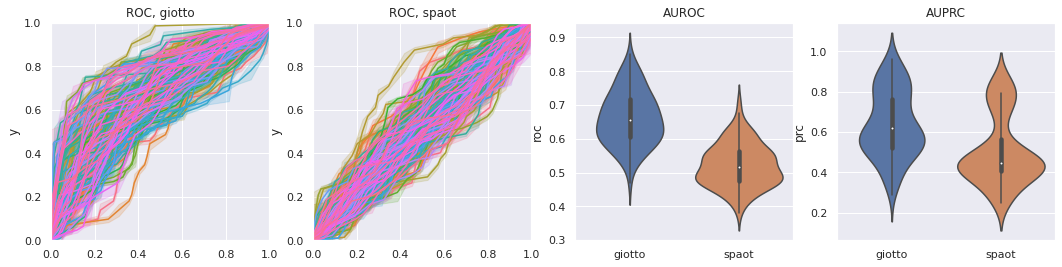

In [11]:
df_plt = get_results(dirs, gio=True)

In [ ]:
def get_results(dirs, talk=False, gio=False):
    df = pd.DataFrame({"method": [], "prc": [], "roc": []})
    df_plt = pd.DataFrame()
    
    dirs = []

    for tree in [1]:
        for ncell in [500, 800]:
            for ngene in [110, 200, 500]:
                for sigma in [0.1, 0.5]:
                    for seed in [1, 2, 3, 4]:
                        root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                        dirs.append(root_dir)
    
    seed = 0
    count = 0
    for root_dir in dirs:
        seed += 1
        spaot = pd.read_csv(os.path.join(root_dir, 'spaot_results.csv'), index_col=0)
        
        gt = pd.DataFrame(0, index=spaot.index, columns=spaot.columns)
        cci_table = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
        for index, row in cci_table.iterrows():
            gt.loc[f"{row['ligand']}-{row['receptor']}", f"CT{row['ct1']}-CT{row['ct2']}"] = 1
        gt = gt.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        # print(gt.values.sum() / gt.size)
        spaot = spaot.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        
        assert spaot.size == gt.size

        y_true = gt.reindex(sorted(gt.columns), axis=1).to_numpy().reshape(-1)
        y_aot = spaot.reindex(sorted(spaot.columns), axis=1).to_numpy().reshape(-1)
        
        if gio:
            giotto = pd.read_csv(os.path.join(root_dir, 'giotto_result_PI.csv'), index_col=0)
            giotto = giotto.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
            y_giotto = giotto.reindex(sorted(giotto.columns), axis=1).to_numpy().reshape(-1)
            # print(spaot.size, giotto.size)
            if (spaot.size != giotto.size):
                continue
            assert spaot.size == giotto.size 
        
        if talk:
            spatalk = pd.read_csv(os.path.join(root_dir, 'spatalk_result.csv'), index_col=0)
            for idx in gt.columns:
                if idx not in spatalk.columns:
                    spatalk[idx] = 0
            y_talk = spatalk.reindex(sorted(spatalk.columns), axis=1).to_numpy().reshape(-1)
            y_talk = 1 - np.clip(y_talk * 120, 0, 1)
            assert spaot.size == spatalk.size 

        # return y_true, y_aot
        
        def get_prc_roc(y_pred):
            prc = average_precision_score(y_true, y_pred)
            roc = roc_auc_score(y_true, y_pred)
            return prc, roc

        if talk:
            df.loc[len(df.index)] = ["spatalk", *get_prc_roc(y_talk)]
        if gio:
            df.loc[len(df.index)] = ["giotto", *get_prc_roc(y_giotto)]
        df.loc[len(df.index)] = ["spaot", *get_prc_roc(y_aot)]
        
        if talk:
            fpr, tpr, _ = roc_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "talk", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "talk", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        if gio:
            fpr, tpr, _ = roc_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "giotto", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "giotto", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        count += 1
        
        fpr, tpr, _ = roc_curve(y_true, y_aot)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "aot", "metric": "roc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        precision, recall, _ = precision_recall_curve(y_true, y_aot)
        # print(precision, recall)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "aot", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
    df_plt["seed"] = df_plt["seed"].astype("category")
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    for i in range(1):
        for j in range(2):
            axs[i, j].set_ylim(0, 1)
            axs[i, j].set_xlim(0, 1)
    if talk:
        sns.lineplot(df_plt[(df_plt["method"] == "talk") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0, 2]).set(title="ROC, spatalk", ylim=(0, 1))
        sns.lineplot(df_plt[(df_plt["method"] == "talk") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1, 2]).set(title="PRC, spatalk", ylim=(0, 1))
    
    if gio:
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0, 0]).set(title="ROC, giotto", xlabel="", ylim=(0, 1))
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1, 0]).set(title="PRC, giotto", xlabel="", ylim=(0, 1))
    
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[0, 1]).set(title="ROC, spaot", xlabel="", ylim=(0, 1))
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1, 1]).set(title="PRC, spaot", xlabel="", ylim=(0, 1))
    sns.violinplot(df, y="roc", x="method", ax=axs[0, 2]).set(title="AUROC", xlabel="")
    sns.violinplot(df, y="prc", x="method", ax=axs[0, 3]).set(title="AUPRC", xlabel="")
    
    for i in range(1):
        for j in range(2):
            axs[i, j].legend([],[], frameon=False)
    
    fig.savefig(f"unif_cci_tree1.pdf")
    return df